# Librerias

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from tensorflow import data as tf_data
import keras
from keras import layers

seed = 42
keras.utils.set_random_seed(seed)

IMG_SIZE = (256, 256)   
BATCH = 8
AUTOTUNE = tf.data.AUTOTUNE

# Cargar el modelo completo (arquitectura + pesos + configuración)
model = keras.models.load_model("/kaggle/input/catdog-model-efficientnetb7/keras/default/1/efficientnetb7_finetuned_catdogs.keras")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug (Sequential)                │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 8, 8, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,762,972 (285.20 MB)

 Trainable params: 5,331,361 (20.34 MB)

 Non-trainable params: 58,768,887 (224.19 MB)

 Optimizer params: 10,662,724 (40.68 MB)

# Datos de Entrenamiento

Cargamos los datos de entrenamiento y aumentamos el dataset aplicando algunas transformaciones

Usamos prefetch para ejecutar en paralelo la preparación de cada batch con la CPU

In [3]:
train_ds = keras.utils.image_dataset_from_directory(
    "/kaggle/input/u-tad-dogs-vs-cats-2025/train/train",
    validation_split=0.2, subset="training", seed=seed,
    image_size=IMG_SIZE, batch_size=BATCH, label_mode="binary"
)
val_ds = keras.utils.image_dataset_from_directory(
    "/kaggle/input/u-tad-dogs-vs-cats-2025/train/train",
    validation_split=0.2, subset="validation", seed=seed,
    image_size=IMG_SIZE, batch_size=BATCH, label_mode="binary"
)

augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomContrast(0.10),
], name="aug")

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


# Transfer Learning

Reutilizamos el modelo EfficientNetB7 y le quitamos la cabecera (ya que está diseñado para 1000 clases, pero nuestro problema es binario)

Congelamos el modelo e introducimos nuestra cabecera. Así aprovechamos el conocimiento del modelo aprendido en ImageNet (dataset con el que fue entrenado), reduciendo el tiempo de entrenamiento y mejorando el rendimiento.

Utilizamos GlobalAveragePooling2D en vez de Flatten para reducir el número de parámetros y resumir cada mapa de características en un solo valor representativo.

Se implementaron tres callbacks: ModelCheckpoint para guardar el mejor modelo según el AUC de validación, EarlyStopping para detener el entrenamiento cuando no se observan mejoras, y ReduceLROnPlateau para ajustar la tasa de aprendizaje en caso de estancamiento

Como métrica confiable usamos AUC (Area Under the Curve) en vez de accuracy

In [5]:
base = keras.applications.EfficientNetB7(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,)
)
base.trainable = False

inp = keras.Input(IMG_SIZE + (3,))
x = augment(inp, training=True)           
x = base(x, training=False)             
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(1, activation="sigmoid", dtype="float32")(x)
model = keras.Model(inp, out)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

cbs_head = [
    keras.callbacks.ModelCheckpoint("b7_head.keras", save_best_only=True, monitor="val_auc", mode="max"),
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=2, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1),
]

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history_head = model.fit(
    train_ds, validation_data=val_ds,
    epochs=5, callbacks=cbs_head, verbose=0
)

# Fine Tuning

Descongelamos parcialmente las capas superiores del modelo preentrenado para ajustar sus pesos al dominio específico de perros y gatos.

Durante esta etapa se utiliza una tasa de aprendizaje reducida para preservar las representaciones generales aprendidas en ImageNet, permitiendo al modelo refinar sus filtros y mejorar la discriminación de las clases sin sobreentrenar.

In [ ]:
# Cargamos el mejor del transfer learning
model.load_weights("b7_head.keras")

# Descongelamos las ultimas N capas
base.trainable = True
N = 12
for layer in base.layers[:-N]:
    layer.trainable = False
for layer in base.layers[-N:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

cbs_ft = [
    keras.callbacks.ModelCheckpoint("b7_ft.keras", save_best_only=True, monitor="val_auc", mode="max"),
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
]

history_ft = model.fit(
    train_ds, validation_data=val_ds,
    epochs=8, callbacks=cbs_ft, verbose=0
)

### Plot the learning curves

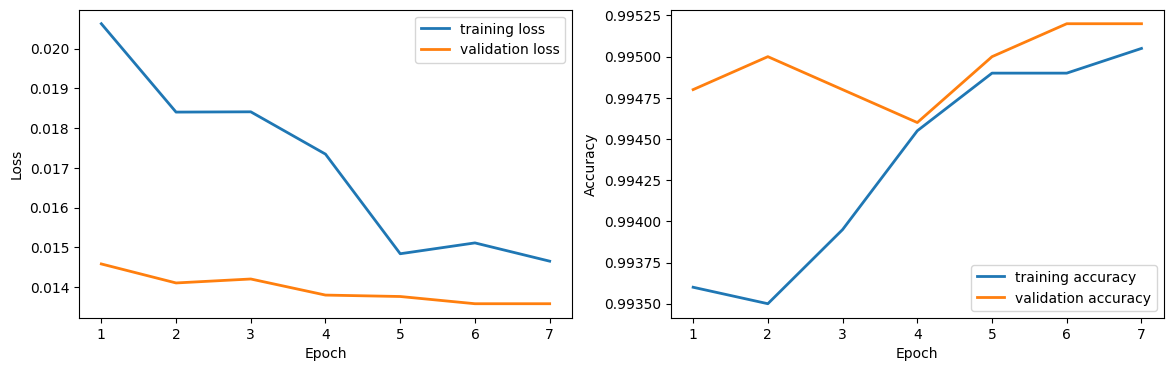

In [5]:
logs = pd.DataFrame(history_ft.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[1:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[1:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[1:,"accuracy"], lw=2, label='training accuracy')
plt.plot(logs.loc[1:,"val_accuracy"], lw=2, label='validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.show()

### Save the trained model

In [7]:
model.save("/kaggle/working/efficientnetb7_finetuned_catdogs.keras")

### Evaluate model performance using the `supplementary_data`

In [8]:
supplementary_ds = keras.utils.image_dataset_from_directory(
    "/kaggle/input/u-tad-dogs-vs-cats-2025/supplementary_data/supplementary_data",
    image_size=IMG_SIZE, batch_size=BATCH, label_mode="binary", shuffle=False
).prefetch(AUTOTUNE)

model.evaluate(supplementary_ds, return_dict=True, verbose=1)

Found 300 files belonging to 2 classes.
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9420 - auc: 0.6295 - loss: 0.1545


{'accuracy': 0.8999999761581421,
 'auc': 0.9815040230751038,
 'loss': 0.254585862159729}

### Create predictions for all of the test images
(Do not modify this section)

Modificación de predicciones por el cambio de categorical a binary (es más coherente usar binary al ser un problema binario)

In [14]:
folder_path = "/kaggle/input/u-tad-dogs-vs-cats-2025/test/test"

predictions_dict = {}

# Umbral de decisión
THRESH = 0.5

for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    
    # save the image name
    file_name = img.split('/')[-1]
    file_no_extension = file_name.split('.')[0]
    
    img = keras.utils.load_img(img, target_size=IMG_SIZE)
    img_array = keras.utils.img_to_array(img)
    img_array = keras.ops.expand_dims(img_array, 0)

    # Obtener probabilidad de clase positiva (perro)
    proba = float(model.predict(img_array, verbose=0).squeeze())

    # Convertir a etiqueta (0 = gato, 1 = perro)
    label = int(proba >= THRESH)

    # save the predictions to a dictionary
    predictions_dict[int(file_no_extension)] = label

### Save your predictions to a competition submission file

In [15]:
submission = pd.DataFrame(predictions_dict.items(), columns=["id", "label"]).sort_values(by='id', ascending=True)
submission.to_csv('submission.csv',index=False)

# print numbers of each class label
submission["label"].value_counts()

label
0    614
1    453
Name: count, dtype: int64